In [ ]:
!pip install pystan
!pip install fbprophet
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.3 MB/s 
     |████████████████████████████████| 9.8 MB 37.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
#Importing libraries
import numpy as np 
from scipy.stats import randint
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
%matplotlib inline
import matplotlib as mpl
from fbprophet import Prophet
from math import sqrt
from sklearn.metrics import mean_squared_error

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ls'/content/gdrive/My Drive/Thesis'

dataframe_dma_flow_1D.csv       dataframe_flow_variable_60min.csv
dataframe_dma_flow_60min.csv    DMA_225.csv
dataframe_flow_1D.csv           DMA_468.csv
dataframe_flow_variable_1D.csv  persistence_results.pkl


In [ ]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/dataframe_flow_variable_60min.csv")
data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'])
data.rename( columns={'Unnamed: 0':'Date_time','225':'DMA_225'}, inplace=True )


In [ ]:
data_DMA225 = data[['Date_time','DMA_225','tempC','HeatIndexC','FeelsLikeC','WindChillC','windspeedKmph','sunHour','precipMM','humidity']]

In [ ]:
data_DMA225_indexed = data_DMA225.set_index('Date_time')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb14450d8d0>,
      dtype=object)

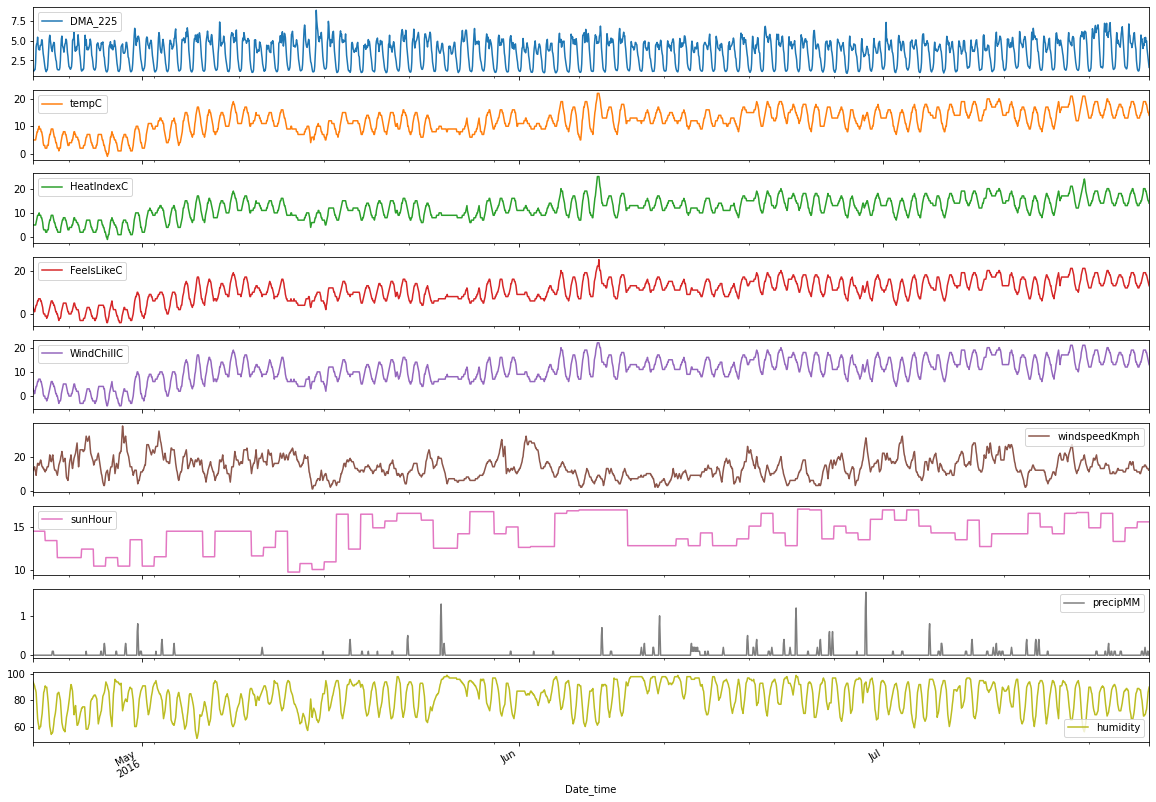

In [ ]:
mpl.rcParams['figure.figsize'] = (20, 15)
mpl.rcParams['axes.grid'] = False

data_DMA225_indexed[['DMA_225','tempC','HeatIndexC','FeelsLikeC','WindChillC','windspeedKmph','sunHour','precipMM','humidity']].plot(subplots=True)

In [ ]:
#Statistical information
data_DMA225_indexed.describe()

,DMA_225,tempC,HeatIndexC,FeelsLikeC,WindChillC,windspeedKmph,sunHour,precipMM,humidity
count,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000
mean,3.562107,11.943388,12.059783,10.769475,10.768116,13.920290,14.180435,0.022509,82.723279
std,1.638267,4.128977,4.158292,5.100604,5.097210,6.153009,1.964704,0.100184,10.948533
min,0.861250,-1.000000,-1.000000,-4.000000,-4.000000,1.000000,9.700000,0.000000,51.000000
25%,1.805750,9.000000,9.000000,8.000000,8.000000,9.000000,12.800000,0.000000,74.000000
50%,3.972250,12.000000,12.000000,11.000000,11.000000,13.000000,14.300000,0.000000,85.000000
75%,4.833500,15.000000,15.000000,15.000000,15.000000,18.000000,15.800000,0.000000,92.000000
max,8.916750,22.000000,25.000000,25.000000,22.000000,38.000000,17.100000,1.600000,99.000000


In [ ]:
#general Information
data_DMA225_indexed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2016-04-22 00:00:00 to 2016-07-22 23:00:00
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DMA_225        2208 non-null   float64
 1   tempC          2208 non-null   int64  
 2   HeatIndexC     2208 non-null   int64  
 3   FeelsLikeC     2208 non-null   int64  
 4   WindChillC     2208 non-null   int64  
 5   windspeedKmph  2208 non-null   int64  
 6   sunHour        2208 non-null   float64
 7   precipMM       2208 non-null   float64
 8   humidity       2208 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 172.5 KB


In [ ]:
#Checking for null values
data_DMA225_indexed.isnull().sum()

DMA_225          0
tempC            0
HeatIndexC       0
FeelsLikeC       0
WindChillC       0
windspeedKmph    0
sunHour          0
precipMM         0
humidity         0
dtype: int64

In [ ]:
# Making hourly data 
hourly_data = data_DMA225_indexed.resample('h').sum()

In [ ]:
#Resetting index
hourly_data_index = hourly_data.reset_index()
#Renaming columns
hourly_data_index = hourly_data_index.rename(columns= {'Date_time': 'ds', 'DMA_225':'y'})
hourly_data_index.shape

(2208, 10)

In [ ]:
#Train and test split
split = 240
train = hourly_data_index[:-240]
test = hourly_data_index[-240:]

In [ ]:
model = Prophet() 
model.add_regressor('tempC')
model.add_regressor('HeatIndexC')
model.add_regressor('FeelsLikeC')
model.add_regressor('WindChillC')
model.add_regressor('windspeedKmph')
model.add_regressor('sunHour')
model.add_regressor('precipMM')
model.add_regressor('humidity')

model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
# Forecast / Predict

future_prediction = model.make_future_dataframe(periods = test.shape[0], freq = '1H')  
forecast_prediction = model.predict(test)
forecast_prediction[['ds', 'yhat']]

,ds,yhat
0,2016-07-13 00:00:00,1.425755
1,2016-07-13 01:00:00,1.193593
2,2016-07-13 02:00:00,0.958291
3,2016-07-13 03:00:00,0.931699
4,2016-07-13 04:00:00,1.388468
...,...,...
235,2016-07-22 19:00:00,4.656960
236,2016-07-22 20:00:00,3.843046
237,2016-07-22 21:00:00,2.918224
238,2016-07-22 22:00:00,2.218369


In [ ]:
# Making final df of original and predicted value
fp = forecast_prediction[['ds', 'yhat']]
fd=pd.merge(test, fp, on="ds")

In [ ]:
#Calculate rmse
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(fd.y,fd.yhat))
rmse = round(rmse, 3)
print (" The root mean square vaue on testset: ",rmse)

 The root mean square vaue on testset:  0.801


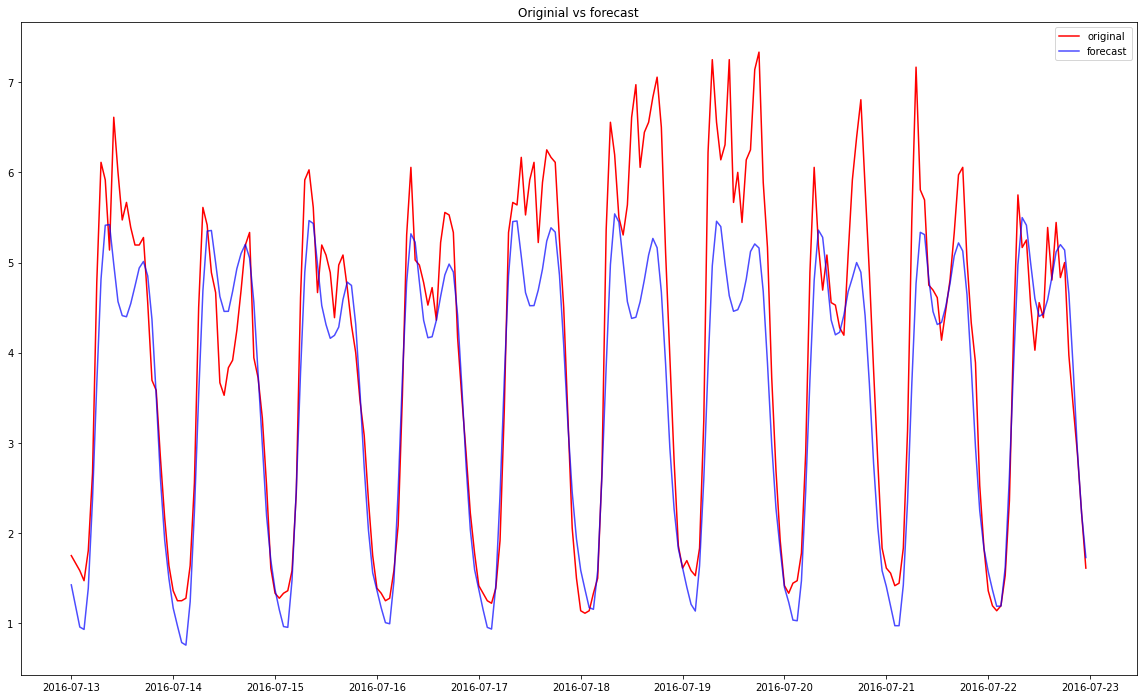

In [ ]:
# Plotting original and predicted graph:
plt.figure(figsize=(20, 12))
plt.plot(fd.ds, fd.y, color='red', label='original')
plt.plot(fd.ds, fd.yhat, color='blue', label='forecast', alpha=0.7)
plt.title('Originial vs forecast')
plt.legend()
plt.show()